In [49]:
%pylab inline
import scipy 
import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


In [6]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

In [7]:
def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

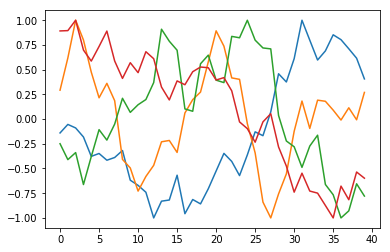

In [16]:
#plot(np.tanh(np.random.randn(10)))
def makeRandomWalk(len):
    pt = zeros(len)
    pt[0] = np.random.randn(1)
    for n in range(pt.size-1):
        pt[n+1] = pt[n] + np.random.randn(1)
    pt = pt - np.min(pt)
    pt = (pt / np.max(pt) * 2) - 1
    return pt


plot(np.array([makeRandomWalk(40) for x in np.zeros(4)]).T)

In [25]:
pattern1 = np.array([makeRandomWalk(40) for x in np.zeros(4)]).T

patterns = np.zeros(1, dtype=np.object)
patterns[0] = pattern1
print(patterns[0])

[[  3.46656190e-01  -1.00000000e+00   7.82231801e-01   3.61108769e-01]
 [  5.43362235e-01  -6.91977496e-01   7.55482405e-01   4.41212441e-02]
 [  6.76953483e-01  -5.80294501e-01   1.00000000e+00   3.91951349e-01]
 [  5.69979223e-01  -4.48839064e-01   7.59069318e-01   2.83749536e-01]
 [  4.41162723e-01  -4.58729043e-01   6.19193593e-01   7.68097580e-01]
 [  2.51495346e-02  -6.11030370e-01   5.27084501e-01   4.39927917e-01]
 [ -4.71159453e-01  -7.00398918e-01   7.19793867e-01   7.42516369e-01]
 [ -6.54765513e-01  -8.71941656e-01   7.06643794e-01   3.32034186e-01]
 [ -8.59051065e-01  -8.65355242e-01   7.99007645e-01   2.64171932e-01]
 [ -1.00000000e+00  -9.05233049e-01   7.44567705e-01   1.44758855e-01]
 [ -7.39093792e-01  -8.15977421e-01   9.27153678e-01   9.48750657e-02]
 [ -5.75959020e-02  -6.34478343e-01   6.56591088e-01   6.79496299e-02]
 [ -7.62305543e-03  -3.20048588e-01   5.53975663e-01  -3.06252772e-01]
 [  4.54806737e-01  -2.91746147e-01   6.22951610e-01  -3.37353981e-01]
 [  4.

In [36]:
win = 2 * (np.random.rand(8, 4) - 0.5)
print(win)
u = patterns[0].take(0, mode='wrap', axis=0)
print(u)
print(win.dot(vstack(u)))
print(win.dot(u))
print(vstack(win.dot(u)))

[[-0.70673014 -0.86900976  0.32090637  0.20889417]
 [ 0.03217957 -0.55844244  0.03414222 -0.96474158]
 [-0.90101109 -0.73842169  0.52457431 -0.2312211 ]
 [-0.25494237 -0.46444175 -0.52210795  0.359893  ]
 [ 0.38508118  0.8326073   0.14555411  0.05323305]
 [-0.99104902 -0.22295989  0.3928047   0.81648825]
 [ 0.06941706 -0.48219356 -0.99947102 -0.25937321]
 [ 0.5423043   0.11042243  0.60830213 -0.87824167]]
[ 0.34665619 -1.          0.7822318   0.36110877]
[[ 0.95047406]
 [ 0.24792817]
 [ 0.75292336]
 [ 0.09761547]
 [-0.56603656]
 [ 0.481512  ]
 [-0.36922254]
 [ 0.23626322]]
[ 0.95047406  0.24792817  0.75292336  0.09761547 -0.56603656  0.481512
 -0.36922254  0.23626322]
[[ 0.95047406]
 [ 0.24792817]
 [ 0.75292336]
 [ 0.09761547]
 [-0.56603656]
 [ 0.481512  ]
 [-0.36922254]
 [ 0.23626322]]


In [96]:
def computeConceptor(net, i_pattern, alpha):
#     print('Computing conceptor, alpha: ', alpha)
    Cs = np.zeros(4, dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(net['p']['N'])))

    C =  U.dot(Snew).dot(U.T);
    Cs[0] = C
    Cs[1] = U
    Cs[2] = diag(Snew)
    Cs[3] = diag(S)

    return Cs

def testConceptor(net, cs, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    C = cs[0]
    for i_trial in range(trials):
        x_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        z_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        x = 0.5 * np.random.randn(net['p']['N'],1) * 0.0
        z = x
        for n in range(recallTestLength + net['p']['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
            x = C.dot(z)
            xPrev = x
            if (n > net['p']['washoutLength']):
                x_CTestPL[:,n-net['p']['washoutLength']] = x.T
                z_CTestPL[:,n-net['p']['washoutLength']] = z.T

        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)

def plotConceptorPattern(net, cs, recallTestLength, i_pattern):
    NIns = net['p']['patts'][0].shape[1];
    x_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    z_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    p_CTestPL = np.zeros((NIns, recallTestLength, net['p']['patts'].shape[0]))
    C = cs[0]
    x = 0.5 * np.random.randn(net['p']['N'],1) * 0
    z = x
    for n in range(recallTestLength + net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        xPrev = x
        if (n > net['p']['washoutLength']):
            x_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
    outputPatterns = p_CTestPL[:,:,i_pattern]
    print(outputPatterns.shape)
    targetPatterns = np.array([net['p']['patts'][i_pattern].take(x, mode='wrap', axis=0) for x in arange(recallTestLength)]).T
    print(targetPatterns.shape)
    scores = np.zeros(targetPatterns.shape[0])
    for i_outputPattern in range(targetPatterns.shape[0]):
        templateScan = np.correlate(outputPatterns[i_outputPattern][:net['p']['patts'][0].shape[0]*2],net['p']['patts'][0][:,i_outputPattern])
        matchPoint = np.argmax(templateScan)
        if (matchPoint > 0):
            outputPattern = outputPatterns[i_outputPattern][matchPoint:]
            targetPattern = targetPatterns[i_outputPattern][:-matchPoint]
        subplot(4,1,i_outputPattern+1)
#         scores[i_outputPattern] = nrmse(outputPatterns[i_outputPattern], targetPatterns[i_outputPattern]) 
#         plot(outputPatterns[i_outputPattern])
#         plot(targetPatterns[i_outputPattern])
        scores[i_outputPattern] = nrmse(outputPattern, targetPattern) 
        plot(outputPattern)
        plot(targetPattern)
    return scores

In [97]:
loadedNets[bestNetwork]['p']['patts'][0][:,0]

array([ 0.34665619,  0.54336224,  0.67695348,  0.56997922,  0.44116272,
        0.02514953, -0.47115945, -0.65476551, -0.85905107, -1.        ,
       -0.73909379, -0.0575959 , -0.00762306,  0.45480674,  0.42715894,
        0.26709071,  0.29461683,  0.50618872,  0.33940988,  0.45315667,
        0.10037422,  0.14583277, -0.44939463, -0.05467025,  0.02845027,
        0.31529918,  0.64937642,  0.43128331,  1.        ,  0.76504876,
        0.72019993,  0.7698897 ,  0.33976233,  0.68201311,  0.70141296,
        0.1197109 , -0.10774083, -0.48060285, -0.33975422, -0.50078692])

In [68]:
np.array([loadedNets[bestNetwork]['p']['patts'][0].take(x, mode='wrap', axis=0) for x in arange(10)])

array([[ 0.34665619, -1.        ,  0.7822318 ,  0.36110877],
       [ 0.54336224, -0.6919775 ,  0.7554824 ,  0.04412124],
       [ 0.67695348, -0.5802945 ,  1.        ,  0.39195135],
       [ 0.56997922, -0.44883906,  0.75906932,  0.28374954],
       [ 0.44116272, -0.45872904,  0.61919359,  0.76809758],
       [ 0.02514953, -0.61103037,  0.5270845 ,  0.43992792],
       [-0.47115945, -0.70039892,  0.71979387,  0.74251637],
       [-0.65476551, -0.87194166,  0.70664379,  0.33203419],
       [-0.85905107, -0.86535524,  0.79900765,  0.26417193],
       [-1.        , -0.90523305,  0.74456771,  0.14475886]])

In [101]:
#create a random reservoir and load it with patterns using Jaeger's method

def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    NIns = p['patts'][0].shape[1];
    print("Inputs: " ,NIns)
    WinRaw = 2 * (np.random.rand(p['N'], NIns) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
#     xCollector = np.zeros((p['N'], p['learnLength']))
#     pCollector = np.zeros((NIns, p['learnLength']))
    x = np.zeros((p['N'],1))
    
    totalDataLength = p['learnLength'] * p['patts'].size
    totalLearnLength = totalDataLength - (p['patts'].size * p['washoutLength']); 
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((NIns, 0));
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    print('Loading patterns: ', end='')
    for i_pattern in range(p['patts'].size):
        print(i_pattern, " ", end='')
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((NIns, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt.take(n, mode='wrap', axis=0)
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(vstack(u)))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[:, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
    print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
    print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
    print("NRMSE W: ", NRMSE_W, " :: ", end='')
    print("absSize W: ", absSize_W)

    return locals()

    

# def computeConceptors(p, net, alphas):
#     print('Computing conceptors, alphas: ', alphas)
#     Cs = np.zeros((4, p['patts'].size), dtype=np.object)
#     for i_pattern in range(p['patts'].size):
#         R = net['patternRs'][0,i_pattern]
#         [U,s,V] = svd(R)
#         S = diag(s)
#         Snew = (S * linalg.inv(S + pow(alphas[i_pattern], -2) * np.eye(p['N'])))

#         C =  U.dot(Snew).dot(U.T);
#         Cs[0,i_pattern] = C
#         Cs[1,i_pattern] = U
#         Cs[2,i_pattern] = diag(Snew)
#         Cs[3,i_pattern] = diag(S)
#     return locals()
            
# def plotConceptorPatterns(p, cNet, subr, suboff, recallTestLength):
#     x_CTestPL = np.zeros((3, recallTestLength, p['patts'].size))
#     p_CTestPL = np.zeros((1, recallTestLength, p['patts'].size))
#     for i_pattern in range(p['patts'].size):
#         C = cNet['Cs'][0,i_pattern]
#         x = 0.5 * np.random.randn(p['N'],1)
#         for n in range(recallTestLength + p['washoutLength']):
#             xOld = x
#             Wtarget = (cNet['net']['W'].dot(x))
#             x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))
#             x = C.dot(x)
#             xPrev = x
#             if (n > p['washoutLength']):
# #                 x_CTestPL[:,n-p['washoutLength'],i_pattern] = x[0:3].T
#                 p_CTestPL[:,n-p['washoutLength'],i_pattern] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
#     for i_pattern in range(p['patts'].size):
#         ax = subplot(subr, p['patts'].size, suboff + i_pattern + 1)
#         ax.set_title("S:" + str(int(suboff/p['patts'].size)) + ", p: " + str(i_pattern) + ", a: " + str(cNet['alphas'][i_pattern]))
#         plot(p_CTestPL[:,:,i_pattern].T)
#         plot([p['patts'][i_pattern](x) for x in arange(recallTestLength)])
        

    
params = {'N':200, 'NetSR':0.99, 'NetinpScaling':1,'BiasScaling':0.5,'TychonovAlpha':0.0001,
         'washoutLength':patterns[0].shape[0] * 2, 'learnLength':patterns[0].shape[0] * 4, 
          'TychonovAlphaReadout':0.0001,
          'LR': 0.9,
          'patts':patterns
#           'patts':np.array([lambda x:pLoop(x,p_rw1), lambda x: pLoop(x,p_rw2)])
#          'patts':np.array([pJ1, pJ2])
         }



sampleSize = 10
loadedNets = np.zeros(sampleSize, dtype=np.object)
for i_net, net in enumerate(loadedNets):
    print(i_net)
    loadedNets[i_net] = makeLoadedNetwork_v2(params)
nrmses = [x['NRMSE_W'] for x in loadedNets]
bestNetwork = np.argmin(nrmses)
print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_W'], "avg: ", np.mean(nrmses) )

def fitnessf(aperture, *args):
    print(args[0], ".", end='')
    cs = computeConceptor(loadedNets[bestNetwork], args[0], aperture)
    atten = testConceptor(loadedNets[bestNetwork], cs, patterns[0].shape[0] *4)
    return atten

apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=0, xtol=1, args = (x,)) 
             for x in np.arange(params['patts'].shape[0])]
print("Apertures: ", apertures)
patternCs = np.zeros(len(apertures), dtype=np.object)
scores = np.zeros(len(apertures))
for i_patt in range(len(apertures)):
    print(i_patt,".",end='')
    patternCs[i_patt] = computeConceptor(loadedNets[bestNetwork], i_patt, apertures[i_patt])
    



0
Inputs:  4
Loading patterns: 0  
NRMSE readout:  1.70864656923e-06  :: absSize readout:  0.0147083712023
NRMSE W:  2.15439698041e-05  :: absSize W:  0.120734704446
1
Inputs:  4
Loading patterns: 0  
NRMSE readout:  1.67235167018e-06  :: absSize readout:  0.014362397948
NRMSE W:  2.34355324071e-05  :: absSize W:  0.123535037725
2
Inputs:  4
Loading patterns: 0  
NRMSE readout:  2.13966007928e-06  :: absSize readout:  0.0155526835821
NRMSE W:  2.02332175461e-05  :: absSize W:  0.121869383038
3
Inputs:  4
Loading patterns: 0  
NRMSE readout:  2.35410918944e-06  :: absSize readout:  0.0149117343016
NRMSE W:  2.82649283219e-05  :: absSize W:  0.135297001652
4
Inputs:  4
Loading patterns: 0  
NRMSE readout:  1.81186521504e-06  :: absSize readout:  0.0151255998528
NRMSE W:  2.2524199533e-05  :: absSize W:  0.124705379562
5
Inputs:  4
Loading patterns: 0  
NRMSE readout:  1.63440779361e-06  :: absSize readout:  0.0148750316665
NRMSE W:  1.56079502996e-05  :: absSize W:  0.109069605314
6
Inpu

(4, 200)
(4, 200)
[ 0.21477975  0.11124025  0.16451545  0.32947266]


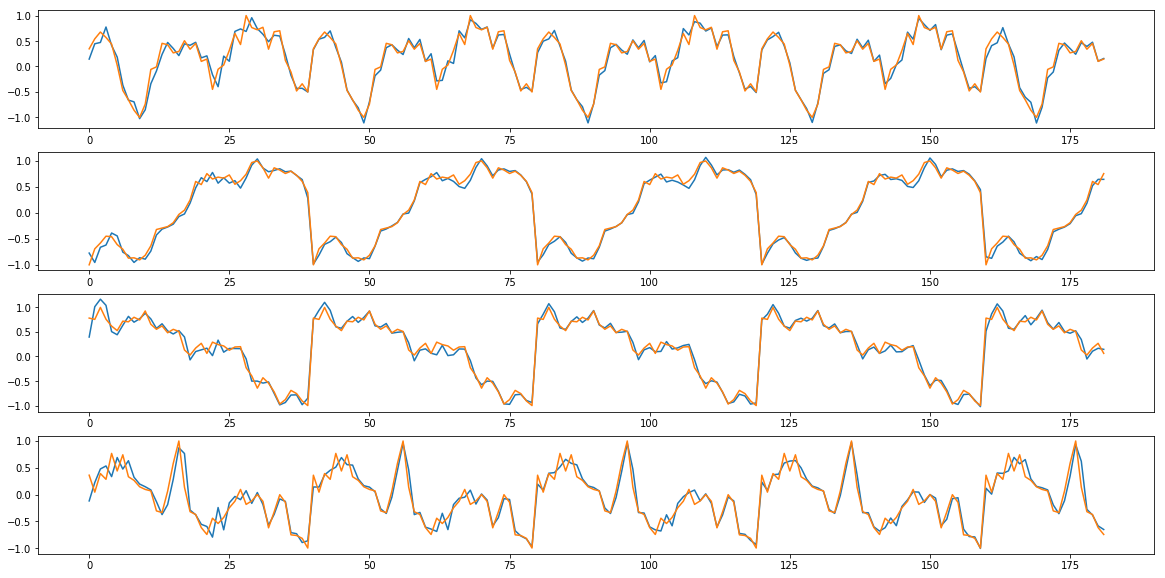

In [102]:
figsize(20,10)
for i_patt in range(len(apertures)):
#     print(i_patt,".",end='')
    print(plotConceptorPattern(loadedNets[bestNetwork], patternCs[i_patt], patterns[0].shape[0] * 5, i_patt))

In [104]:
net1 = {"net":loadedNets[bestNetwork], "Cs":patternCs}

In [1097]:
import dill as pickle
ts = str(datetime.datetime.timestamp(datetime.datetime.now()))
with open(r"models/generator_" + ts + ".pickled", "wb") as output_file:
    pickle.dump(cnet2, output_file, protocol=0)

In [108]:
net1["net"].keys()

dict_keys(['absSize_W', 'NRMSE_W', 'W', 'absSize_readout', 'NRMSE_readout', 'outsRecovered', 'Wout', 'R', 'uOld', 'Wtarget', 'xOld', 'u', 'n', 'pCollector', 'WTargetCollector', 'xOldCollector', 'xCollector', 'patt', 'i_pattern', 'patternRs', 'allTrainOuts', 'allTrainWtargets', 'allTrainOldxArgs', 'allTrainxArgs', 'totalLearnLength', 'totalDataLength', 'x', 'I', 'Wbias', 'Win', 'Wstar', 'WbiasRaw', 'WinRaw', 'NIns', 'WstarRaw', 'Netconnectivity', 'p'])

In [207]:
def createGeneratorState(model):
    return {
        'x':0.5 * np.random.randn(model['net']['p']['N'],1),
        'xOld':np.zeros((model['net']['p']['N'],1)),
        'output':0.0
    }


def iterateGenerator(model, state, excitation, lrMod, conceptorMod):
    net =model['net']
    Cs = model['Cs']
    #conceptor mix
    C = Cs[0][0] * conceptorMod
#     C = (net['Cs'][0,0].dot(mix1)) + (net['Cs'][0,1].dot((mix2))) 
#     C = np.zeros_like(net['Cs'][0,0])
#     for i_morph, morph in enumerate(mixArray):
#         C = C + (net['Cs'][0,i_morph].dot( morph ))
    #excitation
    Wsr = net['W'].dot(excitation)   
    LR = net['p']['LR'] * lrMod
    #update reservoir
    state['xOld'] = state['x']
    Wtarget = Wsr.dot(state['x'])
    state['x'] = ((1.0-LR) * state['xOld']) + (LR * np.tanh(Wtarget + net['Wbias']))
    #apply mixed conceptor
    state['x'] = C.dot(state['x'])
    #compute output layer
    state['output'] = net['Wout'].dot(np.concatenate((state['x'][:,0], np.array([1]))))
    return state
    

In [134]:
net1['Cs'][0][0].shape

(200, 200)

In [208]:
state = createGeneratorState(net1)
print(state.keys())

dict_keys(['x', 'xOld', 'output'])


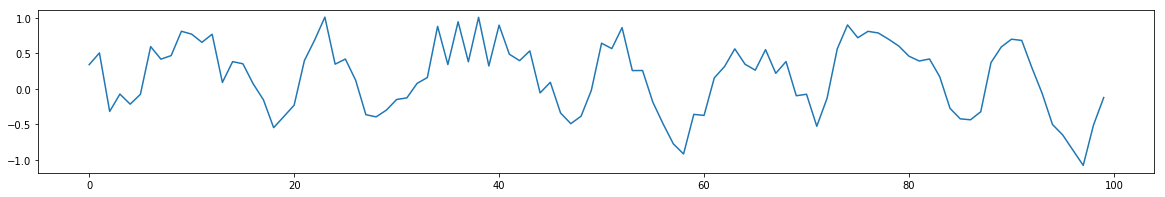

In [227]:
figsize(20,3)
p = zeros(100)
for i in range(p.shape[0]):
    state = iterateGenerator(net1, state, 1.0, 1.0, 1.0)
    for i_n in range(4):
        p[i] = state['output'][0]
plot(p)

In [229]:

from liblo import *
import sys


class MyServer(ServerThread):
    def __init__(self, targetPort, recvPort, onExit, model):
        ServerThread.__init__(self, recvPort)
        print("server created")
        self.onExit = onExit
        self.model = model
        self.state = createGeneratorState(self.model)
        try:
            self.target = Address(targetPort)
        except AddressError as err:
            print (str(err))
            sys.exit()

    def send_value( self, tag, value ):
        send( self.target, tag, value )

    def send_array( self, tag, vals ):
        # we can also build a message object first...
        msg = Message( tag )
        # ... append arguments later...
        for v in vals:
            msg.add(v)
        # ... and then send it
        send(self.target, msg)


    @make_method('/iterate', 'fff')
    def iterate_callback(self, path, args):
        wMod = args[0]
        lrMod = args[1]
        cMod = args[2]
#         print("received message ",path," with arguments: ", args)
        self.state = iterateGenerator(self.model, self.state, wMod, lrMod, cMod)
        self.send_array("/output", self.state['output'])

    @make_method('/exit', None)
    def exit_callback(self, path, args):
#        print("received message ",path," with arguments: ", f)
        print("exit")
        value = self.onExit()
        send(self.target, "/exited" )

    @make_method(None, None)
    def fallback(self, path, args):
        print("received unknown message ", path, args)


def makeOSCServer(targetPort,recvPort,onExit,model):
    try:
        server.free()
    except:
        pass

    try:
        server = MyServer(targetPort,recvPort,onExit,model)
    except err:
        print(str(err))

    return server

In [230]:
def onExit():
    print( "exiting" )
    global keepRunning
    keepRunning = False
    oscserver.free()
    return True
oscserver = makeOSCServer(57120, 57400, onExit, net1)
oscserver.start()

server created
received unknown message  /iterate [1, 0, 1.0, 1.0]
received unknown message  /iterate [1, 0, 1.0, 1.0]
received unknown message  /iterate [1, 0, 1.0, 1.0]
received unknown message  /iterate [1, 0, 1.0, 1.0]
received unknown message  /iterate [1, 0, 1.0, 1.0]
received unknown message  /iterate [1, 0, 1.0, 1.0]
received unknown message  /iterate [1, 0, 1.0, 1.0]
received unknown message  /iterate [1, 0, 1.0, 1.0]


In [206]:
oscserver.free()

In [187]:
oscserver.state

{'output': array([ 1.32907664, -0.15422458,  0.26913375,  0.13709263]),
 'x': array([[  8.45963221e-02],
        [ -7.41019213e-02],
        [  7.56765311e-01],
        [ -9.43960165e-01],
        [ -2.11966836e-01],
        [ -7.57886557e-01],
        [  7.37460889e-01],
        [  6.08594910e-01],
        [ -4.54632188e-02],
        [  9.38944840e-04],
        [ -9.73838314e-01],
        [  2.83905384e-01],
        [  6.01012731e-01],
        [ -4.27045022e-01],
        [ -9.70968216e-01],
        [  7.08803344e-02],
        [ -1.93501918e-01],
        [ -2.47227187e-01],
        [  4.44408515e-01],
        [ -4.61377277e-02],
        [ -4.87262901e-01],
        [  1.80277059e-02],
        [ -1.79871662e-01],
        [  6.79390056e-01],
        [  3.99603594e-01],
        [ -3.16641654e-01],
        [  7.74376331e-02],
        [ -7.81009287e-01],
        [  5.05948042e-01],
        [ -5.82823224e-01],
        [ -6.40251503e-01],
        [ -4.49871576e-02],
        [  2.08265645e-01],